# Import libraries

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import bs4 as bs
import pickle
import requests
from dateutil.relativedelta import relativedelta as rd
from scipy.optimize import minimize
from sklearn.neighbors import DistanceMetric as DM

In [2]:
def compute_results (rs, pos, plot=True, savefig=True):
    
    """ 
    Compute the backtest results using the original returns as a bench mark and after positioning.
        
    """
    
    benchmark = 100*rs.cumsum().apply(np.exp).mean(1)
    myperform = 100*(pos*rs.apply(np.exp)).sum(1).replace(0,1).apply(np.log).cumsum().apply(np.exp)
    
    b_sharpe = benchmark.pct_change().mean()/benchmark.pct_change().std()
    m_sharpe = myperform.pct_change().mean()/myperform.pct_change().std()
    
    b_ar = (1+benchmark.pct_change().mean())**252 - 1
    m_ar = (1+myperform.pct_change().mean())**252 - 1
    
    if plot:
        
        plt.figure(figsize=(15,5))
        benchmark.plot(linewidth=2, color='black')
        myperform.plot(linewidth=2, color='red')
        plt.title('Performance')
        plt.legend(['benchmark', 'portfolio performance'], fontsize=15)
        plt.grid()
        
        print('Sharpe: \n benchmark: {} \n portfolio: {}'.format(round(b_sharpe,5), round(m_sharpe,5)))
        print('Annual return: \n benchmark: {} \n portfolio: {}'.format(round(100*b_ar, 3), round(100*m_ar, 3)))
        
        if savefig: plt.savefig('fig.png')
    
    return myperform

In [3]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

# Get Data

In [4]:
tickers = save_sp500_tickers()

prices = pd.read_csv('SP500 Adj Close.csv', index_col=0, header=0)

andreas_tickers = pd.read_csv('tickers.csv')['Tick'].to_list()
dates = pd.read_csv('Dates.csv')['Date'].to_list()
preds = pd.read_csv('XGBpredictions.csv', index_col=0, header=0)
preds.columns = andreas_tickers
preds.index = pd.to_datetime(dates[1:])

In [5]:
tickers = set(andreas_tickers).intersection(set(prices.columns))
preds = preds[tickers]
prices = prices[tickers]

# Backtest 1

In [6]:
pos = preds.apply(np.sign)
pos = pos.replace(-1,0)
pos = pos.dropna()
pos = (pos.T/pos.sum(1)).T

pos = pos.T.sort_index().T
pos = pos.sort_index()

pos

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
2007-07-02,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
2007-08-01,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
2007-09-04,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
2007-10-01,0.000000,0.006944,0.006944,0.006944,0.006944,0.006944,0.000000,0.006944,0.006944,0.006944,...,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944
2007-11-01,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,...,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-02,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
2018-02-06,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,...,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246
2018-03-01,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,...,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757,0.006757
2018-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.022727,0.000000,0.000000,...,0.000000,0.022727,0.022727,0.022727,0.000000,0.000000,0.000000,0.000000,0.022727,0.022727


In [7]:
rs = prices.astype(float).apply(np.log).diff(1)
rs.index = pd.to_datetime(rs.index)
rs = rs.T.sort_index().T

rs

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,NaN,NaN,NaN,NaN,NaN,0.012334,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016000,NaN,NaN
1970-01-06,NaN,NaN,NaN,NaN,NaN,-0.008097,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002066,NaN,NaN
1970-01-07,NaN,NaN,NaN,NaN,NaN,0.004219,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005903,NaN,NaN
1970-01-08,NaN,NaN,NaN,NaN,NaN,-0.012382,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001918,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,-0.001440,0.002383,-0.001834,-0.006447,-0.000369,-0.003363,-0.001250,-0.019785,-0.001696,0.010355,...,-0.005236,-0.005945,-0.011687,0.001579,0.001298,-0.008939,-0.000790,0.002895,-0.011524,-0.005113
2019-10-15,-0.002335,0.026701,0.005779,0.003229,0.010166,-0.003156,0.001874,0.004578,0.007891,0.008686,...,0.002179,0.015622,-0.005950,0.000946,0.001297,0.003016,-0.002056,0.003463,0.004663,0.019628
2019-10-16,-0.004045,-0.002443,-0.024236,-0.015744,0.000244,0.009331,0.006843,-0.004282,-0.005856,-0.007110,...,0.001496,0.002656,0.006381,0.005783,-0.014796,-0.000921,0.005370,-0.017291,0.003158,-0.013156


In [8]:
pos = pos.reindex(rs.index)
pos = pos.ffill()
pos = pos.dropna()

pos

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-02,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
2007-07-03,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
2007-07-05,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
2007-07-06,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
2007-07-09,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143
2019-10-15,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143
2019-10-16,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143


In [9]:
rs = rs.fillna(0)
rs = rs.reindex(pos.index)

Sharpe: 
 benchmark: 0.03881 
 portfolio: 0.04286
Annual return: 
 benchmark: 11.915 
 portfolio: 13.962


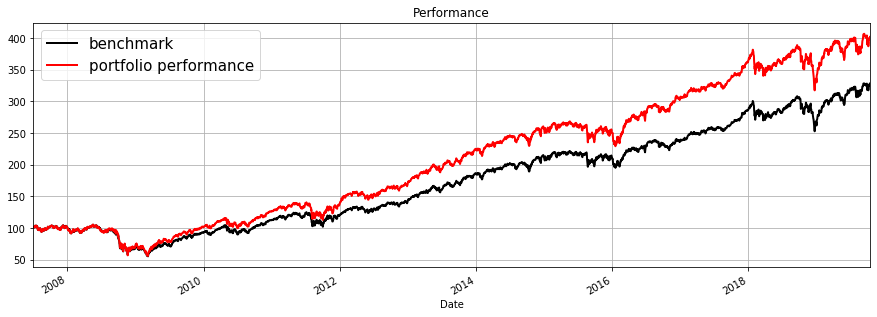

In [10]:
xgb_rs = compute_results (rs, pos, plot=True, savefig=True)

# Supply chain clustering

In [11]:
splyc = pd.read_csv('GSPLY.csv')

/Users/yaoleixu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
splyc = splyc.loc[(splyc['supplier_ticker'].isin(tickers)) & (splyc['customer_ticker'].isin(tickers))]

# Read and format supply chain data

In [13]:
df = splyc[['reporting_year', 'supplier_ticker', 'customer_ticker', 'revenue_dependency']].dropna()
df = df.set_index('reporting_year').sort_index()
df.tail()

,supplier_ticker,customer_ticker,revenue_dependency
reporting_year,,,
2019.0,CAG,WMT,0.25
2019.0,CAG,WMT,0.25
2019.0,CAG,WMT,0.25
2019.0,CAG,WMT,0.25
2019.0,CAG,WMT,0.25


# Visualize structural relationship

In [14]:
tab = df.loc[2018]
companies = list(set(tab['supplier_ticker']).union(set(tab['customer_ticker'])))
w_matrix = pd.DataFrame(index=companies, columns=companies)    

for i in range(tab.shape[0]):
    row = tab.iloc[i]
    w_matrix[row['supplier_ticker']][row['customer_ticker']] = row['revenue_dependency']

w_matrix = w_matrix.fillna(0)

/Users/yaoleixu/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


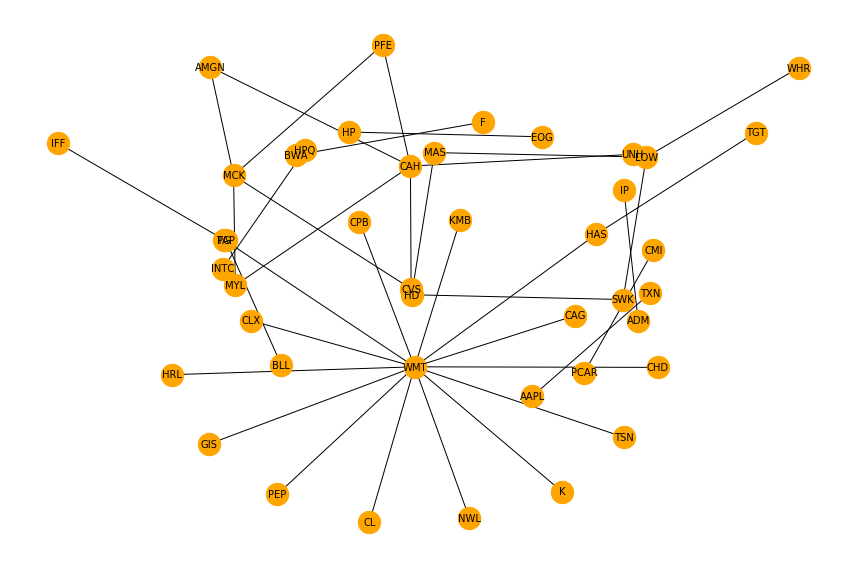

In [15]:
# Transform it in a links data frame (3 columns only):
links = w_matrix.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ abs(links['value'] > 0.0) & (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
fig, ax = plt.subplots()
nx.draw_kamada_kawai(G, with_labels=True, node_color='orange', node_size=500, edgelinewidths=1, font_size=10, ax=ax)
fig.set_size_inches((12,8))
fig.tight_layout()
plt.savefig('fig.png')

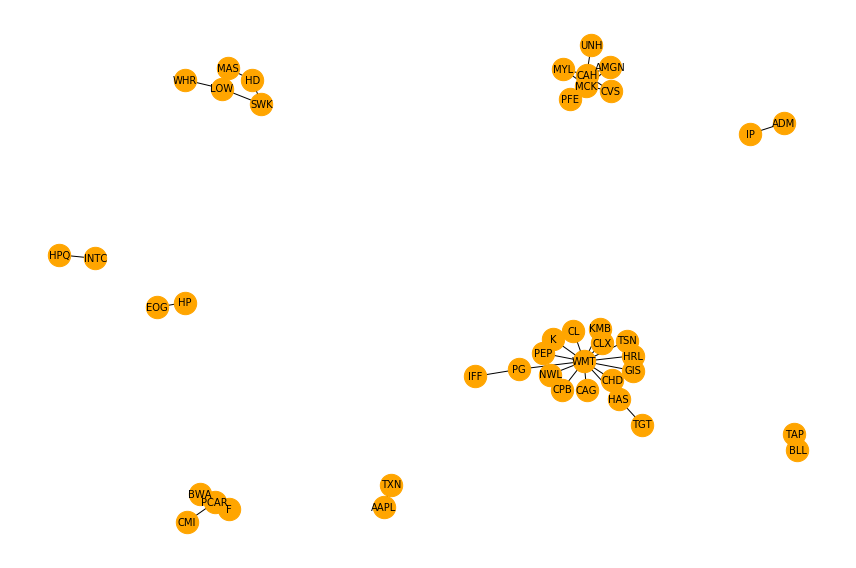

In [16]:
# Plot the network:
fig, ax = plt.subplots()
nx.draw_spring(G, with_labels=True, node_color='orange', node_size=500, edge_color='black', linewidths=1, font_size=10, ax=ax)
fig.set_size_inches((12,8))
fig.tight_layout()
plt.savefig('fig.png')

In [17]:
w_matrix.loc['WMT'][w_matrix.loc['WMT']!=0].index

Index(['CPB', 'CLX', 'HRL', 'GIS', 'PEP', 'CL', 'NWL', 'K', 'PG', 'HAS', 'TSN',
       'CHD', 'CAG', 'KMB'],
      dtype='object')

# Filter preds by structural clustering

In [18]:
preds = preds.dropna()
for t in preds.index:
    
    print(t)
    
    preds_row = preds.loc[t]
    preds_row_ordered = preds_row.sort_values(ascending=False)
    
    # Generate weight matrix ------------------------------
    tab = df.loc[t.year-5:t.year] # get past 5 years
    companies = list(set(tab['supplier_ticker']).union(set(tab['customer_ticker'])))
    w_matrix = pd.DataFrame(index=companies, columns=companies)    

    for i in range(tab.shape[0]):
        row = tab.iloc[i]
        w_matrix[row['supplier_ticker']][row['customer_ticker']] = row['revenue_dependency']

    w_matrix = w_matrix.fillna(0)
    
    # Filter out same cluster stocks & update preds matrix ----------------------------- 
    # Get rid of customer
    for tmp_ticker in preds_row_ordered.index:
        if preds.loc[t][tmp_ticker] != 0:
            if tmp_ticker in w_matrix.columns:
                ticker_cluster = list(w_matrix[tmp_ticker][w_matrix[tmp_ticker]!=0].index)
                for delete_tick in ticker_cluster:
                    preds.loc[t][delete_tick] = 0    
    

2007-07-02 00:00:00
2007-08-01 00:00:00
2007-09-04 00:00:00
2007-10-01 00:00:00
2007-11-01 00:00:00
2007-12-03 00:00:00
2008-01-02 00:00:00
2008-02-01 00:00:00
2008-03-03 00:00:00
2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-02 00:00:00
2008-07-01 00:00:00
2008-08-01 00:00:00
2008-09-02 00:00:00
2008-10-01 00:00:00
2008-11-03 00:00:00
2008-12-01 00:00:00
2009-01-02 00:00:00
2009-02-02 00:00:00
2009-03-02 00:00:00
2009-04-01 00:00:00
2009-05-01 00:00:00
2009-06-01 00:00:00
2009-07-01 00:00:00
2009-08-03 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-02 00:00:00
2009-12-01 00:00:00
2010-01-04 00:00:00
2010-02-01 00:00:00
2010-03-01 00:00:00
2010-04-01 00:00:00
2010-05-03 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-02 00:00:00
2010-09-01 00:00:00
2010-10-01 00:00:00
2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-03 00:00:00
2011-02-01 00:00:00
2011-03-01 00:00:00
2011-04-01 00:00:00
2011-05-02 00:00:00
2011-06-01 00:00:00
2011-07-01 00:00:00
2011-08-01 00:00:00


In [19]:
pos = preds.apply(np.sign)
pos = pos.replace(-1,0)
pos = pos.dropna()
pos = (pos.T/pos.sum(1)).T

pos = pos.T.sort_index().T
pos = pos.sort_index()

pos

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
2007-07-02,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,...,0.007463,0.007463,0.007463,0.007463,0.007463,0.0,0.007463,0.000000,0.007463,0.007463
2007-08-01,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,...,0.007463,0.007463,0.007463,0.007463,0.007463,0.0,0.007463,0.000000,0.007463,0.007463
2007-09-04,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,...,0.007519,0.007519,0.007519,0.007519,0.007519,0.0,0.007519,0.000000,0.007519,0.007519
2007-10-01,0.000000,0.007752,0.007752,0.007752,0.007752,0.007752,0.000000,0.007752,0.007752,0.007752,...,0.007752,0.007752,0.007752,0.007752,0.007752,0.0,0.007752,0.000000,0.007752,0.007752
2007-11-01,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,...,0.007519,0.007519,0.007519,0.007519,0.007519,0.0,0.007519,0.000000,0.007519,0.007519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-02,0.000000,0.007874,0.007874,0.000000,0.000000,0.007874,0.007874,0.007874,0.007874,0.007874,...,0.007874,0.007874,0.007874,0.007874,0.007874,0.0,0.007874,0.007874,0.007874,0.007874
2018-02-06,0.000000,0.008696,0.008696,0.000000,0.000000,0.008696,0.008696,0.008696,0.008696,0.008696,...,0.008696,0.008696,0.008696,0.008696,0.008696,0.0,0.008696,0.008696,0.008696,0.008696
2018-03-01,0.000000,0.007874,0.007874,0.000000,0.000000,0.007874,0.007874,0.007874,0.007874,0.007874,...,0.007874,0.007874,0.007874,0.007874,0.007874,0.0,0.007874,0.007874,0.007874,0.007874
2018-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.026316,0.000000,0.000000,...,0.000000,0.026316,0.026316,0.026316,0.000000,0.0,0.000000,0.000000,0.026316,0.026316


In [20]:
rs = prices.astype(float).apply(np.log).diff(1)
rs.index = pd.to_datetime(rs.index)
rs = rs.T.sort_index().T

rs

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,NaN,NaN,NaN,NaN,NaN,0.012334,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016000,NaN,NaN
1970-01-06,NaN,NaN,NaN,NaN,NaN,-0.008097,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002066,NaN,NaN
1970-01-07,NaN,NaN,NaN,NaN,NaN,0.004219,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005903,NaN,NaN
1970-01-08,NaN,NaN,NaN,NaN,NaN,-0.012382,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001918,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,-0.001440,0.002383,-0.001834,-0.006447,-0.000369,-0.003363,-0.001250,-0.019785,-0.001696,0.010355,...,-0.005236,-0.005945,-0.011687,0.001579,0.001298,-0.008939,-0.000790,0.002895,-0.011524,-0.005113
2019-10-15,-0.002335,0.026701,0.005779,0.003229,0.010166,-0.003156,0.001874,0.004578,0.007891,0.008686,...,0.002179,0.015622,-0.005950,0.000946,0.001297,0.003016,-0.002056,0.003463,0.004663,0.019628
2019-10-16,-0.004045,-0.002443,-0.024236,-0.015744,0.000244,0.009331,0.006843,-0.004282,-0.005856,-0.007110,...,0.001496,0.002656,0.006381,0.005783,-0.014796,-0.000921,0.005370,-0.017291,0.003158,-0.013156


In [21]:
pos = pos.reindex(rs.index)
pos = pos.ffill()
pos = pos.dropna()

pos

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-02,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,...,0.007463,0.007463,0.007463,0.007463,0.007463,0.0,0.007463,0.000000,0.007463,0.007463
2007-07-03,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,...,0.007463,0.007463,0.007463,0.007463,0.007463,0.0,0.007463,0.000000,0.007463,0.007463
2007-07-05,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,...,0.007463,0.007463,0.007463,0.007463,0.007463,0.0,0.007463,0.000000,0.007463,0.007463
2007-07-06,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,...,0.007463,0.007463,0.007463,0.007463,0.007463,0.0,0.007463,0.000000,0.007463,0.007463
2007-07-09,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,...,0.007463,0.007463,0.007463,0.007463,0.007463,0.0,0.007463,0.000000,0.007463,0.007463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,0.000000,0.008403,0.008403,0.000000,0.000000,0.008403,0.008403,0.008403,0.008403,0.008403,...,0.008403,0.008403,0.008403,0.008403,0.008403,0.0,0.008403,0.008403,0.008403,0.008403
2019-10-15,0.000000,0.008403,0.008403,0.000000,0.000000,0.008403,0.008403,0.008403,0.008403,0.008403,...,0.008403,0.008403,0.008403,0.008403,0.008403,0.0,0.008403,0.008403,0.008403,0.008403
2019-10-16,0.000000,0.008403,0.008403,0.000000,0.000000,0.008403,0.008403,0.008403,0.008403,0.008403,...,0.008403,0.008403,0.008403,0.008403,0.008403,0.0,0.008403,0.008403,0.008403,0.008403


In [22]:
rs = rs.fillna(0)
rs = rs.reindex(pos.index)

Sharpe: 
 benchmark: 0.03881 
 portfolio: 0.04368
Annual return: 
 benchmark: 11.915 
 portfolio: 14.293


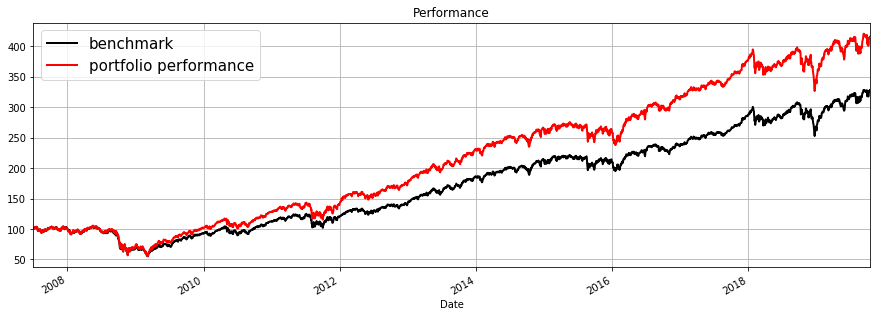

In [23]:
graph_filtered_EW = compute_results (rs, pos, plot=True, savefig=True)

# Equal Vol Weighting 

In [24]:
pos[pos!=0] = 1
pos = pos.reindex(preds.index)
pos

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
2007-07-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2007-08-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2007-09-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2007-10-01,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2007-11-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-02,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2018-02-06,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2018-03-01,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2018-04-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [25]:
rs = prices.astype(float).apply(np.log).diff(1)
rs.index = pd.to_datetime(rs.index)
rs = rs.T.sort_index().T
rs = rs.fillna(0)

rs

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.012334,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016000,0.000000,0.000000
1970-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008097,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002066,0.000000,0.000000
1970-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.004219,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005903,0.000000,0.000000
1970-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012382,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001918,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,-0.001440,0.002383,-0.001834,-0.006447,-0.000369,-0.003363,-0.001250,-0.019785,-0.001696,0.010355,...,-0.005236,-0.005945,-0.011687,0.001579,0.001298,-0.008939,-0.000790,0.002895,-0.011524,-0.005113
2019-10-15,-0.002335,0.026701,0.005779,0.003229,0.010166,-0.003156,0.001874,0.004578,0.007891,0.008686,...,0.002179,0.015622,-0.005950,0.000946,0.001297,0.003016,-0.002056,0.003463,0.004663,0.019628
2019-10-16,-0.004045,-0.002443,-0.024236,-0.015744,0.000244,0.009331,0.006843,-0.004282,-0.005856,-0.007110,...,0.001496,0.002656,0.006381,0.005783,-0.014796,-0.000921,0.005370,-0.017291,0.003158,-0.013156


In [26]:
for t in preds.index:
        
    past_rs = rs.loc[t+rd(years=-1):t][pos.loc[t][pos.loc[t]!=0].index]
    vols = past_rs.std()/past_rs.std().sum()
    pos.loc[t][pos.loc[t][pos.loc[t]!=0].index] = pos.loc[t][pos.loc[t][pos.loc[t]!=0].index]*vols

In [27]:
pos = pos.reindex(rs.index)
pos = pos.ffill()
pos = pos.dropna()

pos

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-02,0.011193,0.005791,0.010829,0.0105,0.005981,0.005651,0.008970,0.009459,0.007258,0.007667,...,0.009688,0.007011,0.004474,0.009249,0.008400,0.0,0.005229,0.000000,0.006769,0.006543
2007-07-03,0.011193,0.005791,0.010829,0.0105,0.005981,0.005651,0.008970,0.009459,0.007258,0.007667,...,0.009688,0.007011,0.004474,0.009249,0.008400,0.0,0.005229,0.000000,0.006769,0.006543
2007-07-05,0.011193,0.005791,0.010829,0.0105,0.005981,0.005651,0.008970,0.009459,0.007258,0.007667,...,0.009688,0.007011,0.004474,0.009249,0.008400,0.0,0.005229,0.000000,0.006769,0.006543
2007-07-06,0.011193,0.005791,0.010829,0.0105,0.005981,0.005651,0.008970,0.009459,0.007258,0.007667,...,0.009688,0.007011,0.004474,0.009249,0.008400,0.0,0.005229,0.000000,0.006769,0.006543
2007-07-09,0.011193,0.005791,0.010829,0.0105,0.005981,0.005651,0.008970,0.009459,0.007258,0.007667,...,0.009688,0.007011,0.004474,0.009249,0.008400,0.0,0.005229,0.000000,0.006769,0.006543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,0.000000,0.007065,0.010379,0.0000,0.000000,0.005096,0.008623,0.012111,0.006361,0.007906,...,0.009998,0.009232,0.005117,0.009501,0.008254,0.0,0.005134,0.006252,0.008871,0.009639
2019-10-15,0.000000,0.007065,0.010379,0.0000,0.000000,0.005096,0.008623,0.012111,0.006361,0.007906,...,0.009998,0.009232,0.005117,0.009501,0.008254,0.0,0.005134,0.006252,0.008871,0.009639
2019-10-16,0.000000,0.007065,0.010379,0.0000,0.000000,0.005096,0.008623,0.012111,0.006361,0.007906,...,0.009998,0.009232,0.005117,0.009501,0.008254,0.0,0.005134,0.006252,0.008871,0.009639


In [28]:
rs = rs.fillna(0)
rs = rs.reindex(pos.index)

Sharpe: 
 benchmark: 0.03881 
 portfolio: 0.04254
Annual return: 
 benchmark: 11.915 
 portfolio: 15.521


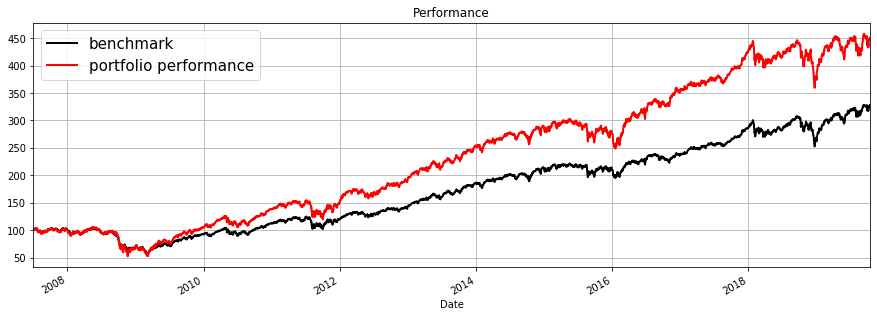

In [29]:
graph_filtered_EV = compute_results (rs, pos, plot=True, savefig=True)

# Minimum Variance Optimization

In [30]:
# Objective function to minimize using the minimizer from scipy
def portfolio_variance (w, cov):   
    var = 100*float(w.T.dot(cov).dot(w)) # note the variance is multiplied for computational reasons
    return var

# Function that computes the optimal weights to minimize the variance
def compute_w_opt (cov, past_rs):
    
    # initialize weights
    w = np.random.random((past_rs.shape[1],1))-0.5

    # Constraints of the optimization
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w)-1})
    bnds = [(0,0.3) for i in range(w.shape[0])]

    # Minimize
    w_opt = minimize(portfolio_variance, w, args=(cov), constraints=cons, bounds=bnds).x
    
    return w_opt


In [31]:
pos[pos!=0] = 1
pos = pos.reindex(preds.index)
pos

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
2007-07-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2007-08-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2007-09-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2007-10-01,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2007-11-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-02,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2018-02-06,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2018-03-01,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2018-04-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [32]:
rs = prices.astype(float).apply(np.log).diff(1)
rs.index = pd.to_datetime(rs.index)
rs = rs.T.sort_index().T
rs = rs.fillna(0)

rs

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.012334,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016000,0.000000,0.000000
1970-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008097,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002066,0.000000,0.000000
1970-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.004219,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005903,0.000000,0.000000
1970-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012382,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001918,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,-0.001440,0.002383,-0.001834,-0.006447,-0.000369,-0.003363,-0.001250,-0.019785,-0.001696,0.010355,...,-0.005236,-0.005945,-0.011687,0.001579,0.001298,-0.008939,-0.000790,0.002895,-0.011524,-0.005113
2019-10-15,-0.002335,0.026701,0.005779,0.003229,0.010166,-0.003156,0.001874,0.004578,0.007891,0.008686,...,0.002179,0.015622,-0.005950,0.000946,0.001297,0.003016,-0.002056,0.003463,0.004663,0.019628
2019-10-16,-0.004045,-0.002443,-0.024236,-0.015744,0.000244,0.009331,0.006843,-0.004282,-0.005856,-0.007110,...,0.001496,0.002656,0.006381,0.005783,-0.014796,-0.000921,0.005370,-0.017291,0.003158,-0.013156


In [33]:
for t in preds.index:
    
    print(t)
    
    past_rs = rs.loc[t+rd(years=-1):t][pos.loc[t][pos.loc[t]!=0].index]
    cov = past_rs.cov()
    w_opt = compute_w_opt (cov, past_rs)

    pos.loc[t][pos.loc[t][pos.loc[t]!=0].index] = w_opt*pos.loc[t][pos.loc[t][pos.loc[t]!=0].index]

2007-07-02 00:00:00
2007-08-01 00:00:00
2007-09-04 00:00:00
2007-10-01 00:00:00
2007-11-01 00:00:00
2007-12-03 00:00:00
2008-01-02 00:00:00
2008-02-01 00:00:00
2008-03-03 00:00:00
2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-02 00:00:00
2008-07-01 00:00:00
2008-08-01 00:00:00
2008-09-02 00:00:00
2008-10-01 00:00:00
2008-11-03 00:00:00
2008-12-01 00:00:00
2009-01-02 00:00:00
2009-02-02 00:00:00
2009-03-02 00:00:00
2009-04-01 00:00:00
2009-05-01 00:00:00
2009-06-01 00:00:00
2009-07-01 00:00:00
2009-08-03 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-02 00:00:00
2009-12-01 00:00:00
2010-01-04 00:00:00
2010-02-01 00:00:00
2010-03-01 00:00:00
2010-04-01 00:00:00
2010-05-03 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-02 00:00:00
2010-09-01 00:00:00
2010-10-01 00:00:00
2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-03 00:00:00
2011-02-01 00:00:00
2011-03-01 00:00:00
2011-04-01 00:00:00
2011-05-02 00:00:00
2011-06-01 00:00:00
2011-07-01 00:00:00
2011-08-01 00:00:00


In [34]:
pos = pos.reindex(rs.index)
pos = pos.ffill()
pos = pos.dropna()

pos

,AAPL,ABT,ADBE,ADM,ADP,AEP,AES,ALB,AME,AMGN,...,VMC,WBA,WEC,WHR,WMB,WMT,XEL,XOM,XRAY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-02,0.006868,0.000000e+00,2.968003e-18,0.0,0.0,7.609744e-18,2.249720e-18,0.000000e+00,0.0,0.000041,...,0.000000e+00,1.172073e-03,0.0,0.000000e+00,0.000000,0.0,9.927226e-19,0.000000,1.423015e-19,0.000000
2007-07-03,0.006868,0.000000e+00,2.968003e-18,0.0,0.0,7.609744e-18,2.249720e-18,0.000000e+00,0.0,0.000041,...,0.000000e+00,1.172073e-03,0.0,0.000000e+00,0.000000,0.0,9.927226e-19,0.000000,1.423015e-19,0.000000
2007-07-05,0.006868,0.000000e+00,2.968003e-18,0.0,0.0,7.609744e-18,2.249720e-18,0.000000e+00,0.0,0.000041,...,0.000000e+00,1.172073e-03,0.0,0.000000e+00,0.000000,0.0,9.927226e-19,0.000000,1.423015e-19,0.000000
2007-07-06,0.006868,0.000000e+00,2.968003e-18,0.0,0.0,7.609744e-18,2.249720e-18,0.000000e+00,0.0,0.000041,...,0.000000e+00,1.172073e-03,0.0,0.000000e+00,0.000000,0.0,9.927226e-19,0.000000,1.423015e-19,0.000000
2007-07-09,0.006868,0.000000e+00,2.968003e-18,0.0,0.0,7.609744e-18,2.249720e-18,0.000000e+00,0.0,0.000041,...,0.000000e+00,1.172073e-03,0.0,0.000000e+00,0.000000,0.0,9.927226e-19,0.000000,1.423015e-19,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,0.000000,8.646813e-19,9.445002e-19,0.0,0.0,3.112823e-02,0.000000e+00,3.858811e-18,0.0,0.000000,...,1.486332e-18,9.675893e-19,0.0,1.115456e-18,0.044546,0.0,0.000000e+00,0.003124,1.944977e-02,0.003216
2019-10-15,0.000000,8.646813e-19,9.445002e-19,0.0,0.0,3.112823e-02,0.000000e+00,3.858811e-18,0.0,0.000000,...,1.486332e-18,9.675893e-19,0.0,1.115456e-18,0.044546,0.0,0.000000e+00,0.003124,1.944977e-02,0.003216
2019-10-16,0.000000,8.646813e-19,9.445002e-19,0.0,0.0,3.112823e-02,0.000000e+00,3.858811e-18,0.0,0.000000,...,1.486332e-18,9.675893e-19,0.0,1.115456e-18,0.044546,0.0,0.000000e+00,0.003124,1.944977e-02,0.003216


In [35]:
rs = rs.fillna(0)
rs = rs.reindex(pos.index)

Sharpe: 
 benchmark: 0.03881 
 portfolio: 0.05518
Annual return: 
 benchmark: 11.915 
 portfolio: 11.641


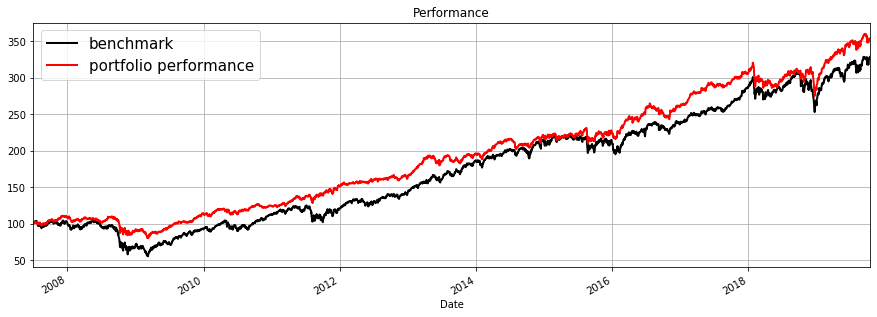

In [36]:
graph_filtered_MV = compute_results (rs, pos, plot=True, savefig=True)

# Total Plot

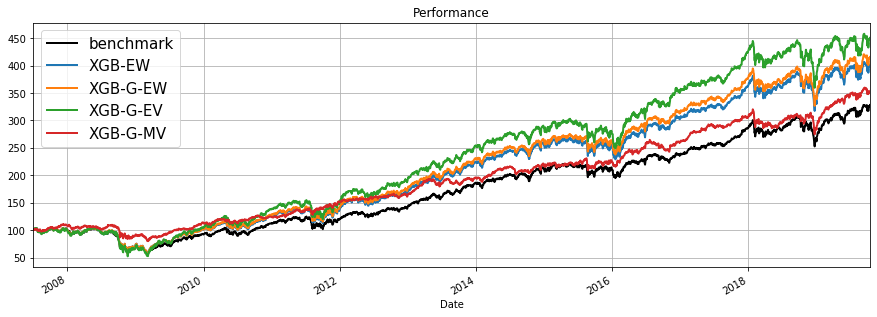

In [37]:
plt.figure(figsize=(15,5))

benchmark = 100*rs.cumsum().apply(np.exp).mean(1)

benchmark.plot(linewidth=2, color='black')
xgb_rs.plot(linewidth=2)
graph_filtered_EW.plot(linewidth=2)
graph_filtered_EV.plot(linewidth=2)
graph_filtered_MV.plot(linewidth=2)

plt.title('Performance')
plt.legend(['benchmark', 'XGB-EW', 'XGB-G-EW', 'XGB-G-EV', 'XGB-G-MV'], fontsize=15)
plt.grid()

plt.savefig('fig.png')